 
# Analyse exploratoire des données

- Analyse de la forme
- Traitement des éventuelles valeurs manquantes
- Analyse du fond
- Analyse des relations & corrélations entre les variables
- Feature selection
- Analyse en Composantes principales
- Clustering

In [1]:
#libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#utils
from Functions.constants import *
from Functions.Common_functions import *

#options
pd.set_option('display.max_row', 200)
pd.set_option('display.max_row', 200)

In [2]:
#Chargement des données
df = load_data()

## Analyse de forme

<ul>
    <li>768 Lignes</li>
    <li>10 Colonnes</li>
</ul>

<div>
    <b>8 features :</b>
    <p>6 quantitatives :</p>
    <ul>
         <li>X1 = Relative compactness</li>
         <li>X2 = Surface area</li>
         <li>X3 = Wall area</li>
         <li>X4 = Roof area</li>
         <li>X5 = Overall height</li>
         <li>X7 = Glazing area</li>
    </ul>
    <p>2 données catégoriques :</p>
    <ul>
         <li>X6 = Orientation</li>
         <li>X8 = Glazing area distr</li>
    </ul>
    <b>2 labels :</b>
    <ul>
         <li>Y1 = Energy <i>(Pour régression)</i></li>
         <li>Y2 = Energy efficiency <i>(Pour classification)</i></li>
    </ul>
</div>

In [3]:
df.shape

(768, 10)

In [4]:
df.head()

Relative compactness  Surface area   Wall area   Roof area  Overall height  \
0              0.982928    530.489958  306.484593  112.002683             7.0   
1              0.983547    519.872380  299.776324  110.048028             7.0   
2              0.979453    516.191221  303.374358  106.408431             7.0   
3              0.977733    518.924089  292.812213  113.055938             7.0   
4              0.903029    552.968920  316.236102  118.366409             7.0   

  Orientation  Glazing area  Glazing area distr     Energy Energy efficiency  
0       North      0.016095                   0  34.263943                 B  
1        East     -0.009387                   0  34.589751                 B  
2       South     -0.000697                   0  38.778048                 C  
3        West      0.000010                   0  37.947808                 C  
4       North     -0.006592                   0  47.675859                 D

In [5]:
df.dtypes.value_counts()

float64    7
object     2
int64      1
dtype: int64

## Valeurs manquantes :
Aucune valeur manquante.

In [6]:
df.isna().sum(axis=0)

Relative compactness    0
Surface area            0
Wall area               0
Roof area               0
Overall height          0
Orientation             0
Glazing area            0
Glazing area distr      0
Energy                  0
Energy efficiency       0
dtype: int64

## Analyse du fond

In [7]:
df.min()

Relative compactness     0.612496
Surface area               501.45
Wall area                 234.338
Roof area                 105.339
Overall height                3.5
Orientation                  East
Glazing area           -0.0240091
Glazing area distr              0
Energy                    10.2115
Energy efficiency               A
dtype: object

On peut remarquer que des valeurs volontairement bruitées n'ont plus aucun sens (surface < 0)<br/>
Il convient de remettre ces valeurs à 0.

In [8]:
num = df._get_numeric_data()
num[num < 0] = 0
df.min()

Relative compactness    0.612496
Surface area              501.45
Wall area                234.338
Roof area                105.339
Overall height               3.5
Orientation                 East
Glazing area                   0
Glazing area distr             0
Energy                   10.2115
Energy efficiency              A
dtype: object

#### Visualisation des différentes variables d'Area

Text(0.5, 0, 'Roof area')

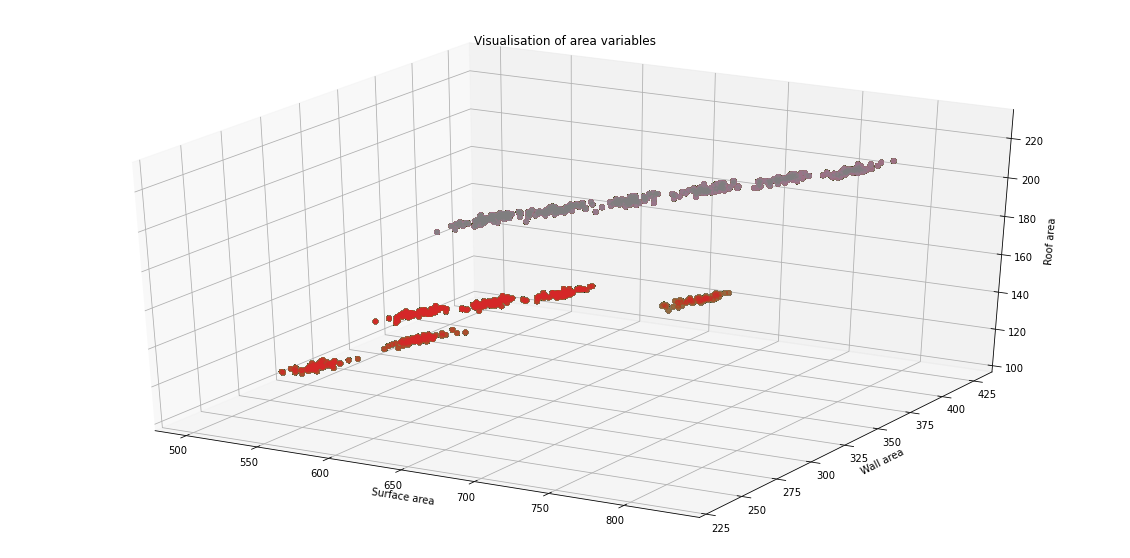

In [9]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
#fig, ax = plt.subplots()
for height in df[X5]:
    ax.scatter(df[X2].where(df[X5]==height), df[X3].where(df[X5]==height), df[X4].where(df[X5]==height), label=height)
ax.set_title("Visualisation of area variables")
ax.set_xlabel(X2)
ax.set_ylabel(X3)
ax.set_zlabel(X4)

On peut remarquer une relation quasiment linéaire entre ces variables lorsqu'on les dissocie en fonction de la variable "Overall Height" :

Pour les batiments ayant une overall Height de 3.5 (en gris sur le graphe), la relation est parfaitement linéaire (légèrement bruitée ici)
Pour les batiments ayant une overall Height de 7, on distingue une relation linéaire pour certains batiments, des batiments s'écartent cependant de cette relation sur le Wall Area

Après un coup d'oeil plus approfondi sur ces colonnes, on peut aisément deviner la relation qui les lie :

In [11]:
print(df[X2] - 2 * df[X4] - df[X3])

0      0.000000e+00
1      5.684342e-14
2     -1.023182e-12
3      0.000000e+00
4      1.023182e-12
           ...     
763   -9.663381e-13
764    5.684342e-14
765    0.000000e+00
766    1.023182e-12
767    1.080025e-12
Length: 768, dtype: float64


X2 = 2*X4 + X3

Surface totale = 2x surface au sol + surface des murs (Logique quand on y pense)


#### Distribution des classes de la target (Energy Efficiency)

A    0.270833
E    0.141927
B    0.141927
F    0.132812
G    0.105469
C    0.104167
D    0.102865
Name: Energy efficiency, dtype: float64

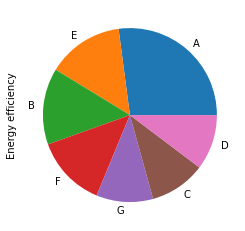

In [9]:
df[Y2].value_counts().plot.pie()
df[Y2].value_counts(normalize=True)

#### observation de la répartition des variables continues

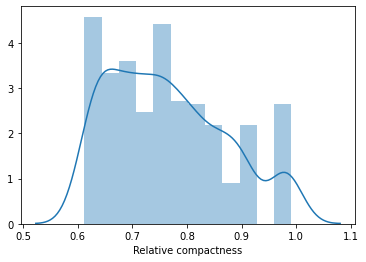

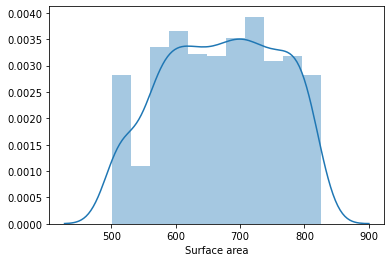

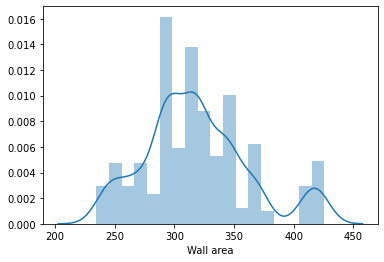

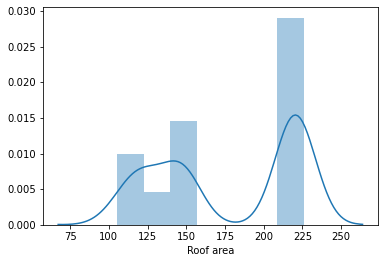

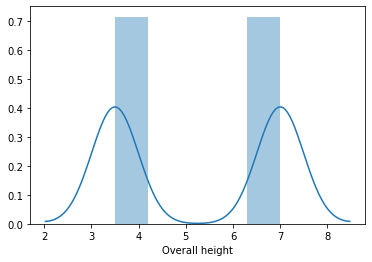

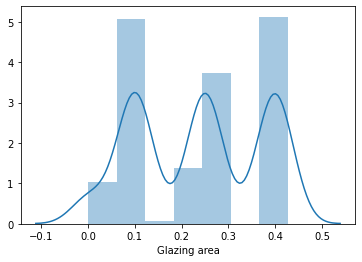

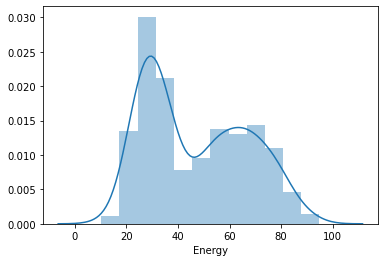

In [10]:
for col in df.select_dtypes(float):
    plt.figure()
    sns.distplot(df[col])

#### Variables qualitatives discretes

In [11]:
for col in df.select_dtypes('object'):
    print(f'{col :-<30}, {df[col].unique()}')

Orientation-------------------, ['North' 'East' 'South' 'West']
Energy efficiency-------------, ['B' 'C' 'D' 'E' 'F' 'A' 'G']


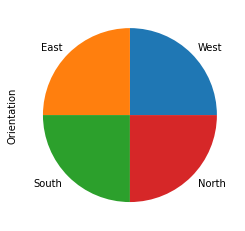

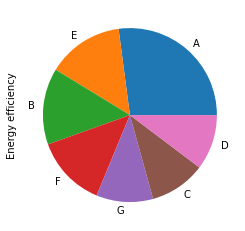

In [12]:
for col in df.select_dtypes('object'):
    plt.figure()
    df[col].value_counts().plot.pie()

## Correlations & Relations

#### Visualisation des relations entre les différentes variable et la target

In [13]:
subdfs = []
labels = df[Y2].unique()
labels.sort()
for i in range(len(labels)):
    subdfs+=[df[df[Y2] == labels[i]]]


C:\Users\thoma\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\thoma\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\thoma\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\thoma\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\thoma\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\thoma\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data

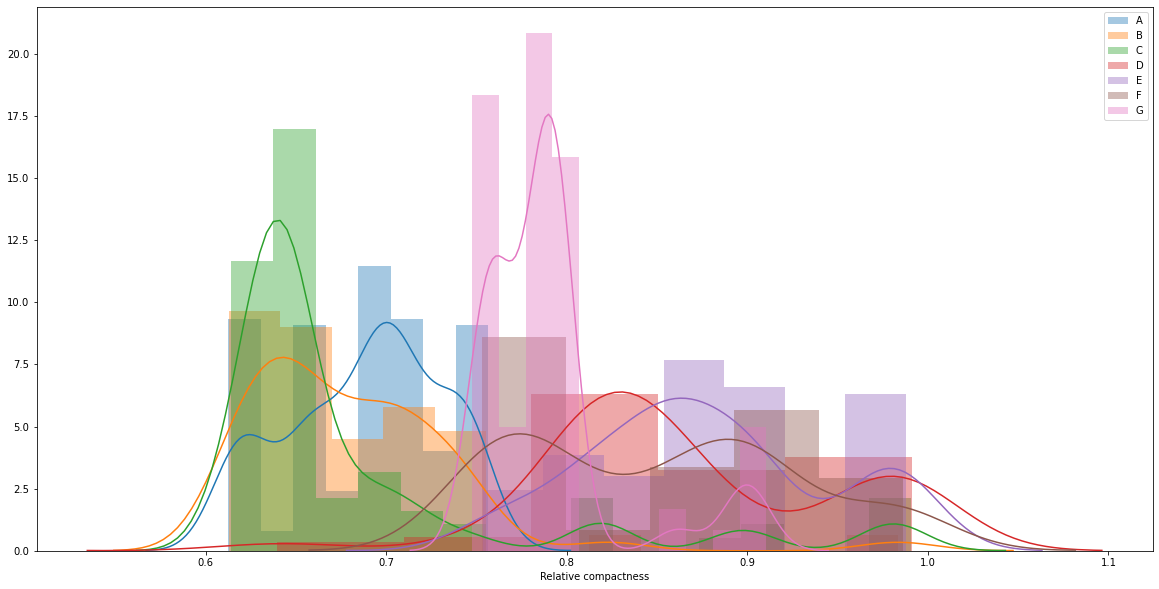

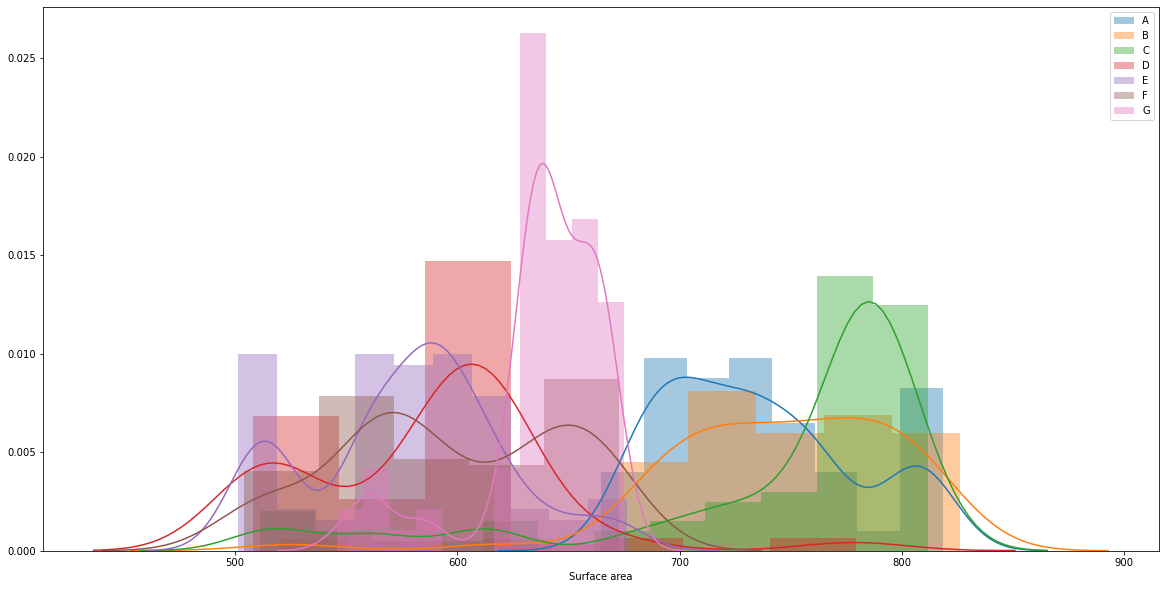

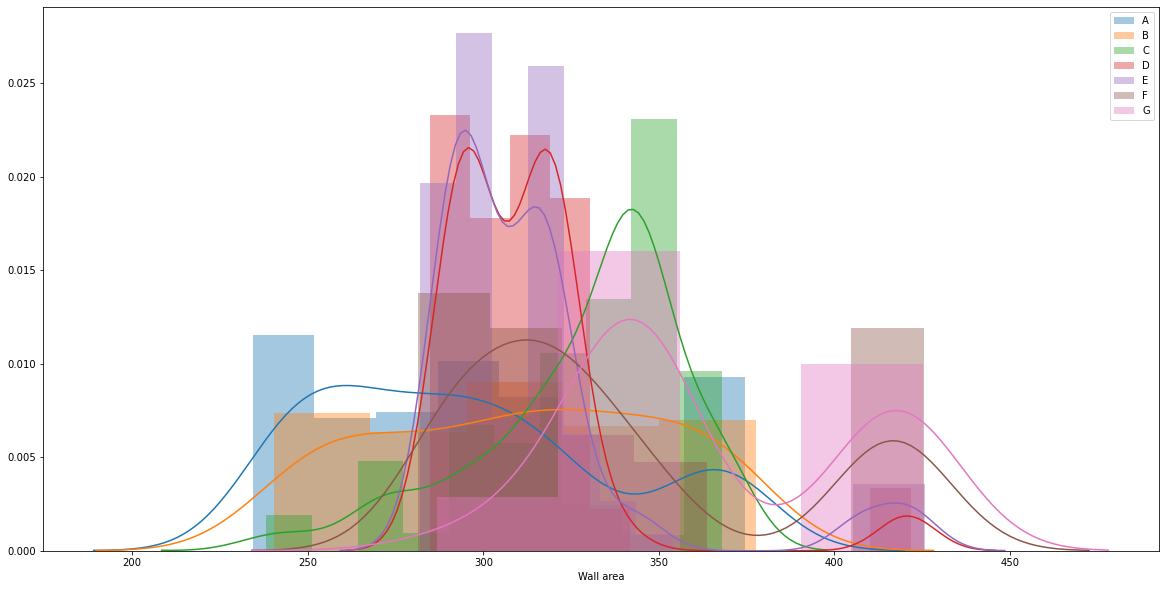

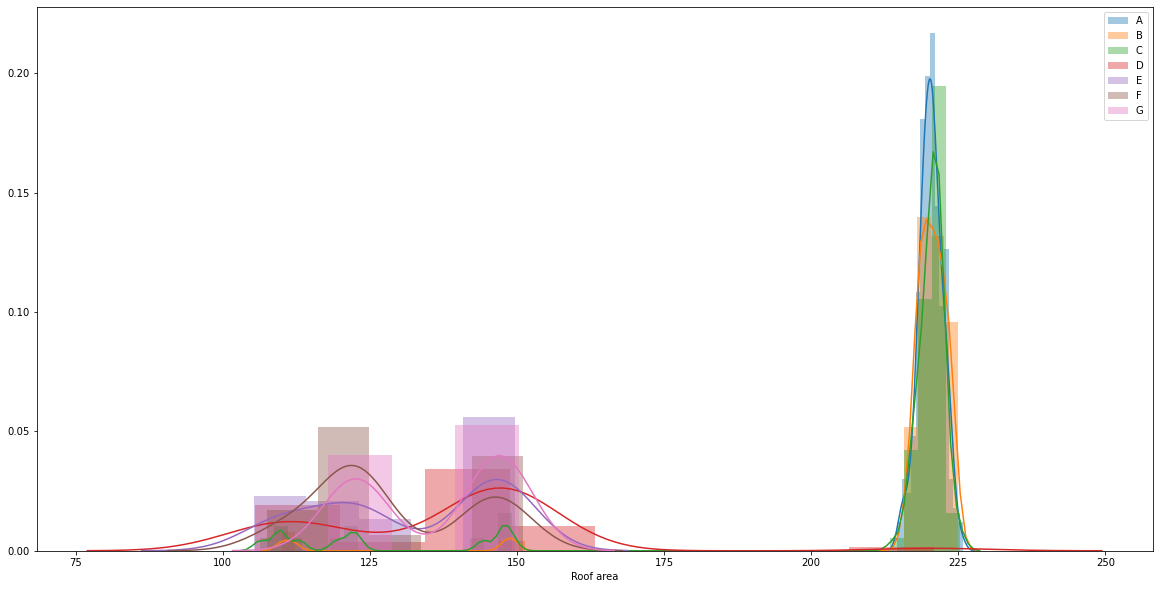

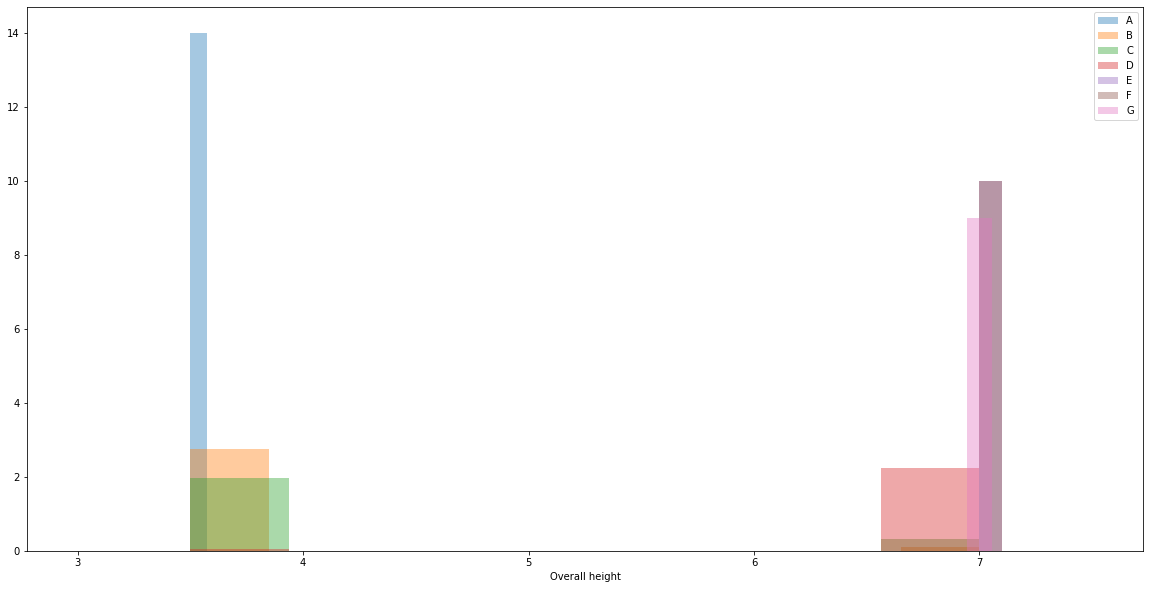

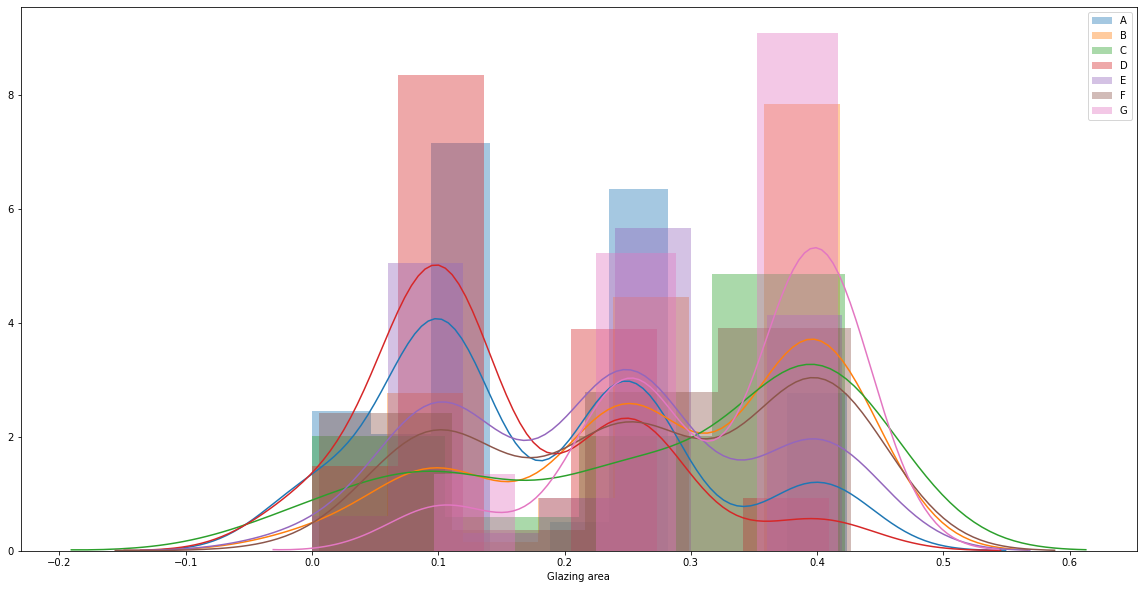

In [14]:
for col in NUMERICAL:
    plt.figure(figsize=(20,10))
    for i in range(len(labels)):
        sns.distplot(subdfs[i][col], label=labels[i])
    plt.legend()

Resultats intéressants pour certaines variables :


<b>Relative Compactness :</b><br />
Il semblerait que les batiments avec une faible <i>Relative Compactness</i> aient plutot des classes d'énergie faibles (A, B, C).
Les batiments de classse G semblent se regrouper autour de 0.7 / 0.8
Il faudrait voir la signification exacte de cette valeur pour emmettre des hypothèses sur cette dernière.
Les classes D, E et F s'étalent, elles, sur des valeurs de <i>Relative Compactness</i> plus forte.

<b> Surface Area</b>
Encore une fois, on observe une distinction des classes :
Les batiments de grande surface semblent avoir des classes d'énergies faibles (A, B, C).
Encore une fois, la classe G se distingue par un pic très centralisé.


<b>Roof Area & Overall height</b>
Enorme Distinction entre les classes faibles (A,B,C) et les classes fortes (D, E, F, G)


#### Correlations

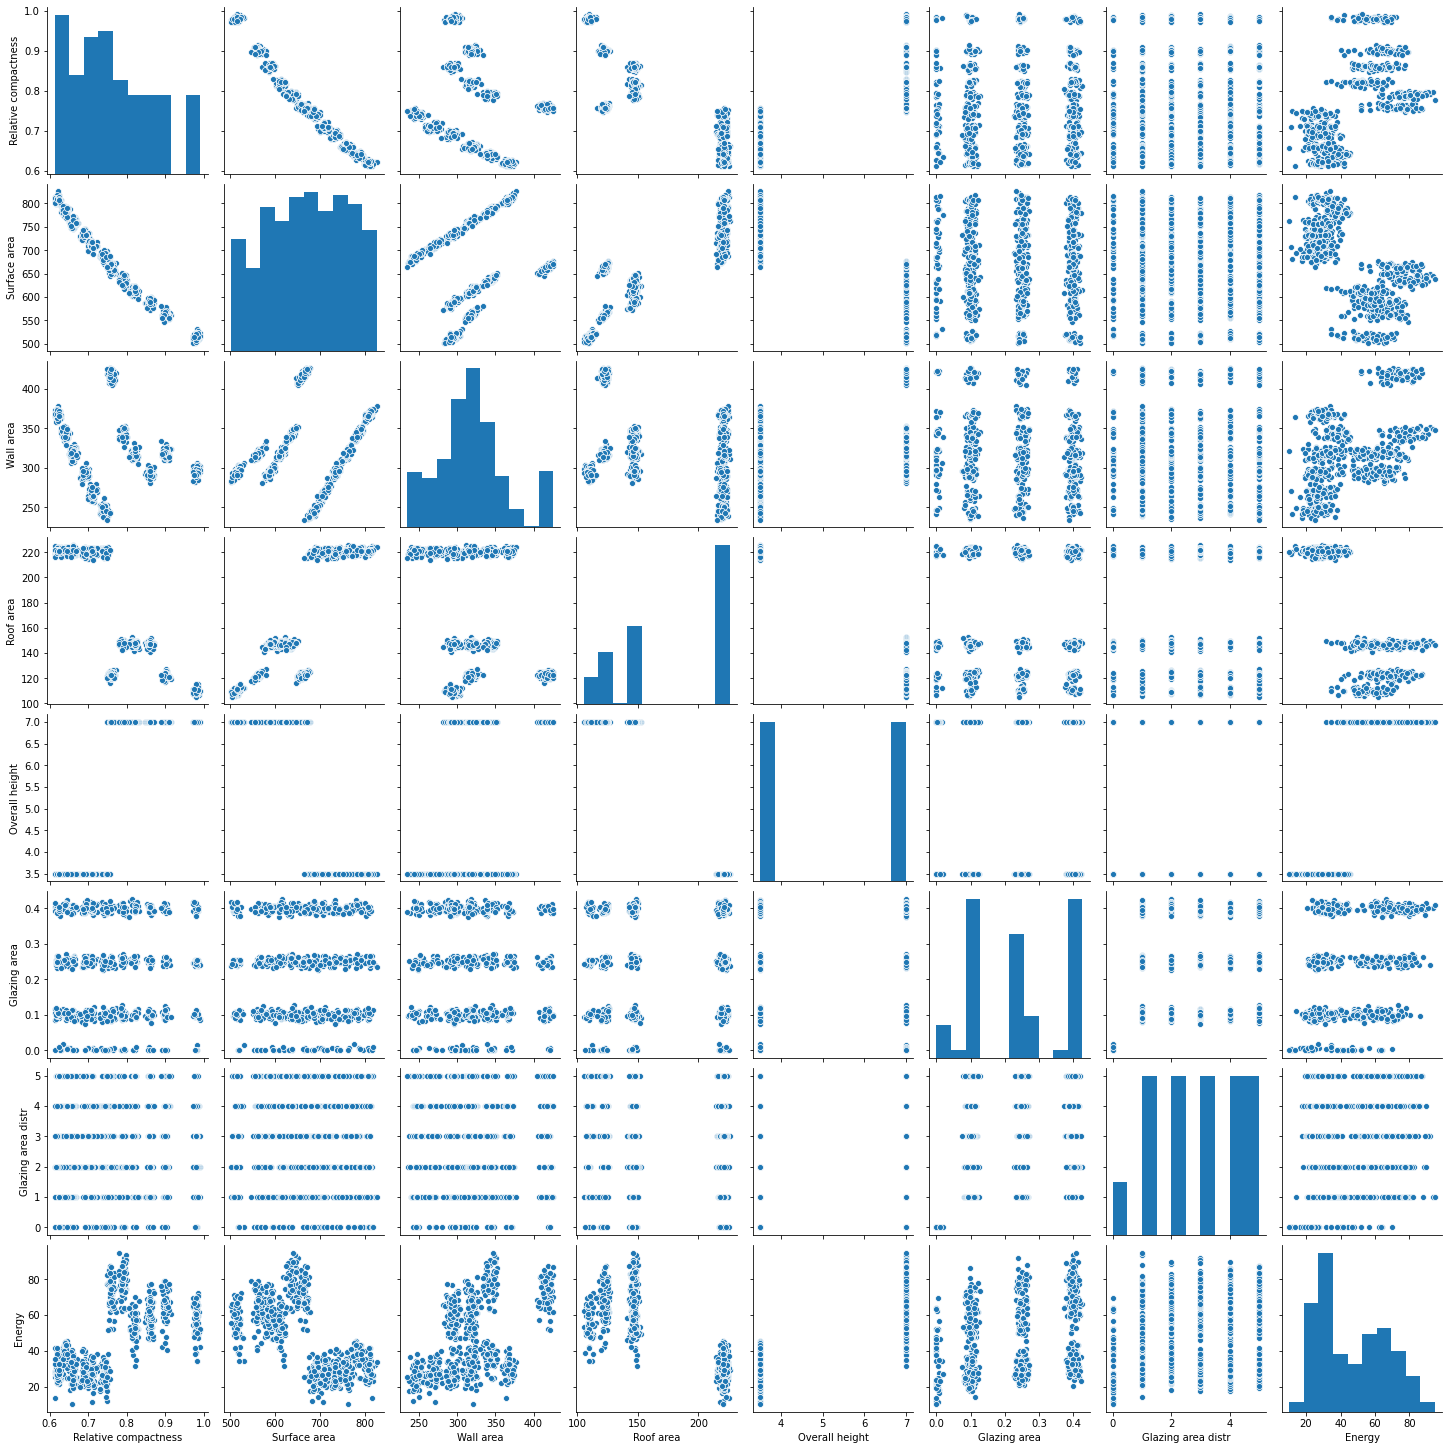

In [15]:
sns.pairplot(df[BASE_COLUMNS])

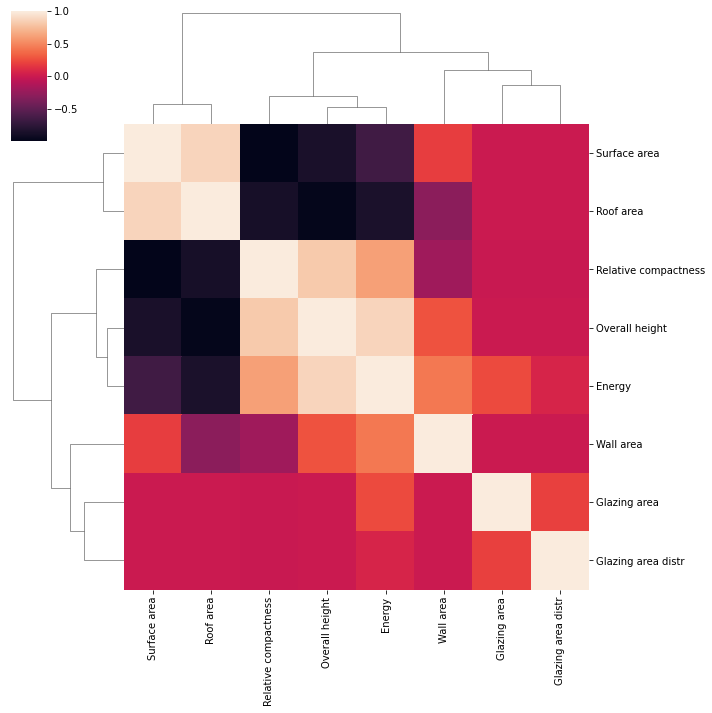

In [16]:
sns.clustermap(df[BASE_COLUMNS].corr())

Forte correlations entre les variables :
 - Roof Area & Surface Area
 - Relative Compactness & Overall height

## Features Selection

#### Variance threshold

On élimine une variable si ça variance est inférieure à un seuil que l'on définit

In [17]:
from sklearn.feature_selection import VarianceThreshold

In [18]:
selector = VarianceThreshold(threshold=0.05)
selector.fit_transform(df[NUMERICAL])

print("Colonnes retenues :")
print(np.array(NUMERICAL)[selector.get_support()])

print("Colonnes refusées :")
np.array(NUMERICAL)[selector.get_support() == False]

Colonnes retenues :
['Surface area' 'Wall area' 'Roof area' 'Overall height']
Colonnes refusées :


array(['Relative compactness', 'Glazing area'], dtype='<U20')

#### SelectKBest

Selectionne les K variables X dont le score du test de dépendance avec Y est le plus élevé

In [19]:
from sklearn.feature_selection import SelectKBest, chi2

In [20]:
chi2(df[NUMERICAL], df[Y2])
#Plus le score est élevé, plus les variables sont dépendantes

(array([7.16745740e+00, 6.01232060e+03, 1.13825734e+03, 7.67246388e+03,
        4.12323151e+02, 1.04610761e+01]),
 array([3.05638227e-001, 0.00000000e+000, 1.10021029e-242, 0.00000000e+000,
        6.26273293e-086, 1.06530297e-001]))

In [21]:
selector = SelectKBest(chi2, k=4)#Séléctionne 5 variable
selector.fit(df[NUMERICAL], df[Y2])
selector.get_support()

print("Colonnes retenues :")
print(np.array(NUMERICAL)[selector.get_support()])

print("Colonnes refusées :")
np.array(NUMERICAL)[selector.get_support() == False]

Colonnes retenues :
['Surface area' 'Wall area' 'Roof area' 'Overall height']
Colonnes refusées :


array(['Relative compactness', 'Glazing area'], dtype='<U20')

Encore une fois, les colonnes rejetées sont les colonnes 'Relative Compactness' et 'Glazing Area'

#### SelectFromModel

Préentraine un estimateur et examine ses coefficients pour voir quelles variables sont les plus importantes

In [22]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import SGDClassifier

In [23]:
selector = SelectFromModel(SGDClassifier(),
                          threshold='mean')
selector.fit_transform(df[NUMERICAL], df[Y2])
selector.get_support()

print("Colonnes retenues :")
print(np.array(NUMERICAL)[selector.get_support()])

print("Colonnes refusées :")
np.array(NUMERICAL)[selector.get_support() == False]
#selector.estimator_.coef_
                    #.mean(axis=0)
                    #.mean()

Colonnes retenues :
['Wall area' 'Roof area' 'Overall height']
Colonnes refusées :


array(['Relative compactness', 'Surface area', 'Glazing area'],
      dtype='<U20')

In [24]:
from sklearn.feature_selection import RFE, RFECV

In [25]:
selector = RFECV(SGDClassifier(random_state=0), step=1, min_features_to_select=4, cv=5)
selector.fit(df[NUMERICAL], df[Y2])
selector.ranking_ #Classement final des variables

array([1, 1, 1, 1, 1, 1])

In [26]:
selector.grid_scores_

array([0.2072235 , 0.20192683, 0.27502759])

## Détection d'anomalies

#### Isolation Forest

In [27]:
from sklearn.ensemble import IsolationForest

In [28]:
isolF = IsolationForest(contamination=0.01)

In [29]:
isolF.fit(df[NUMERICAL])

IsolationForest(contamination=0.01)

In [30]:
isolF.predict(df[NUMERICAL])

array([-1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [31]:
test = pd.Series(isolF.predict(df[NUMERICAL])).unique()
test.sort()

Les outliers seront visualisés plus tard grace à l'ACP

## ACP 

In [48]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

In [49]:
### On part du dataframe normalisé :
std_data = formate_dataset()
target = std_data[Y2]
std_data = std_data[NUMERICAL]
std_data.head()

Relative compactness Surface area  Wall area Roof area Overall height  \
0              2.06355     -1.59779  -0.269786  -1.42786              1   
1               2.0694     -1.71823  -0.422547  -1.47112              1   
2              2.03073     -1.75999  -0.340612  -1.55169              1   
3              2.01447     -1.72899  -0.581134  -1.40454              1   
4              1.30869     -1.34281 -0.0477237  -1.28699              1   

  Glazing area  
0     -1.64028  
1     -1.83179  
2     -1.76649  
3     -1.76117  
4     -1.81079

#### Visualisation des labels

In [73]:
def plot_2DPCA(data, target, target_name = "target"):
    labels = target.unique().copy()
    labels.sort()
    data[target_name] = target
    #print(data)
    plt.figure(figsize=(20,10))
    for value in labels:
        plt.scatter(data[0].where(data[target_name]==value), data[1].where(data[target_name]==value),  label=value)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 12)
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 2')
    plt.title("Visualisation of " + target_name + " on 2 Components PCA")
    
def plot_3DPCA(data, target, target_name ="target"):
    labels = target.unique().copy()
    labels.sort()
    data[target_name] = target
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111, projection='3d')
    for value in labels:
        ax.scatter(data[0].where(data[target_name]==value), 
                    data[1].where(data[target_name]==value),
                    data[2].where(data[target_name]==value),
                    label=value)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 12)
    ax.set_xlabel('Principal component 1')
    ax.set_ylabel('Principal component 2')
    ax.set_zlabel('Principal component 3')
    ax.set_title("Visualisation of " + target_name + " on 3 Components PCA")

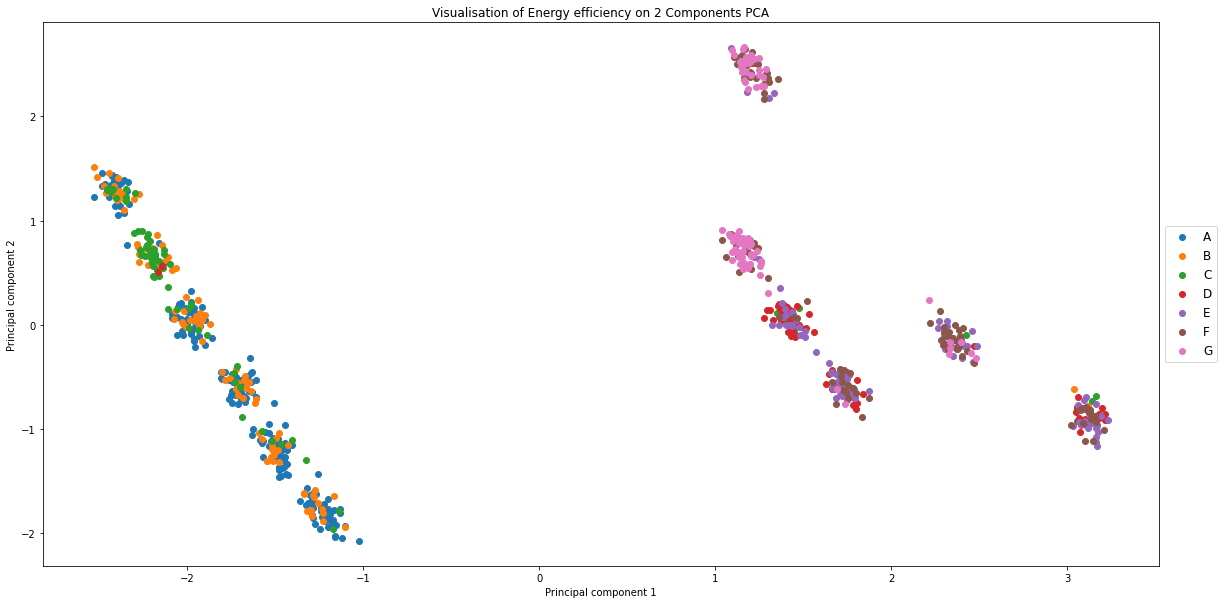

In [52]:
pca = PCA(n_components=2)
X2D = pd.DataFrame(pca.fit_transform(std_data))
plot_2DPCA(X2D, target, Y2)

#### Label groupés en [A,B,C] & [D,E,F] et [G]

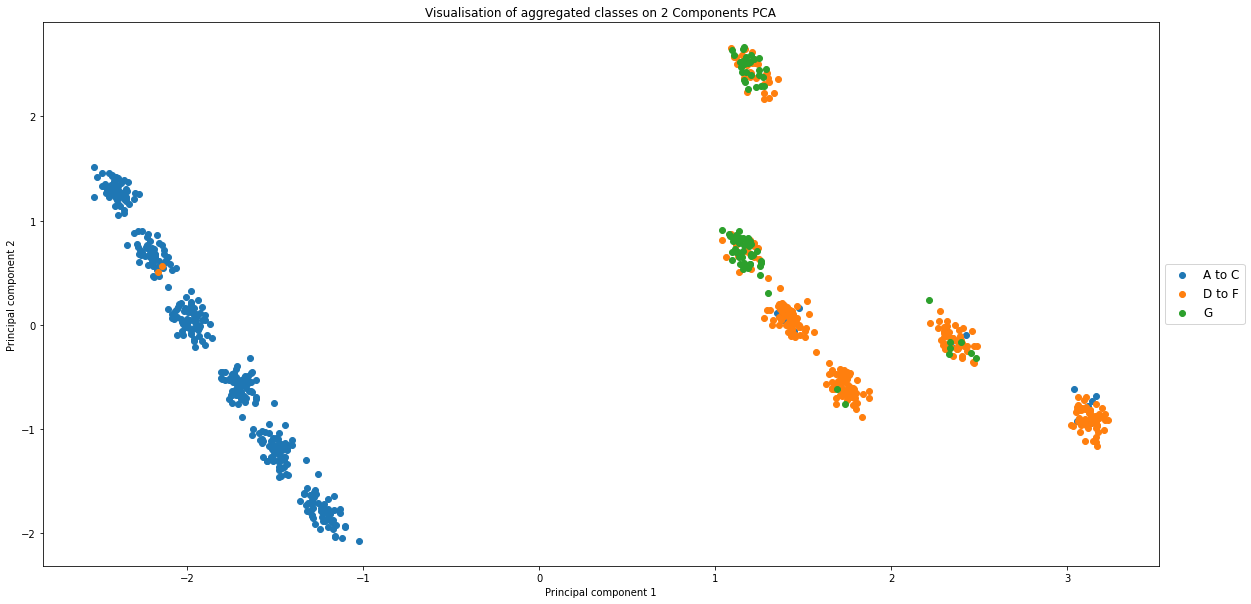

In [77]:
target_grouped = pd.Series("A to C" if label in ["A", "B", "C"] else "D to F" if label in ["D", "E", "F"] else "G" for label in target)
plot_2DPCA(X2D, target_grouped, "aggregated classes")

#### Valeurs Y1

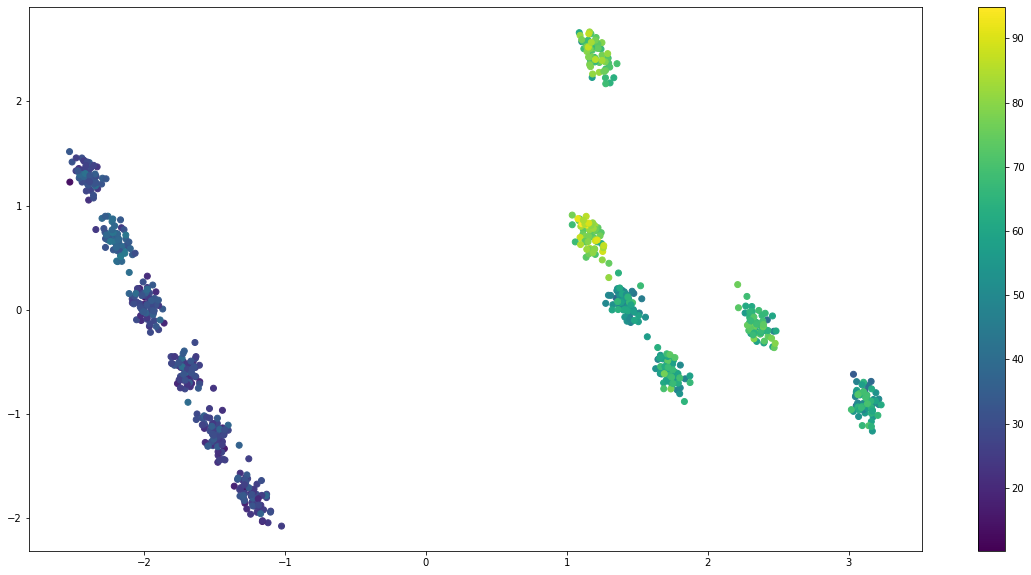

In [71]:
plt.figure(figsize=(20,10))
plt.scatter(X2D[0], X2D[1], c=df[Y1])
plt.colorbar()

#### Analyse des composantes

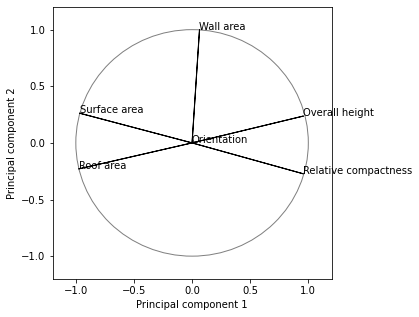

In [72]:
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)

for i, j, nom in zip(coord1,coord2, df.columns.values):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='black')
plt.axis((-1.2,1.2,-1.2,1.2))

# cercle
c=plt.Circle((0,0), radius=1, color='gray', fill=False)
ax.add_patch(c)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.show()


#### Visualisation d'ACP 3D

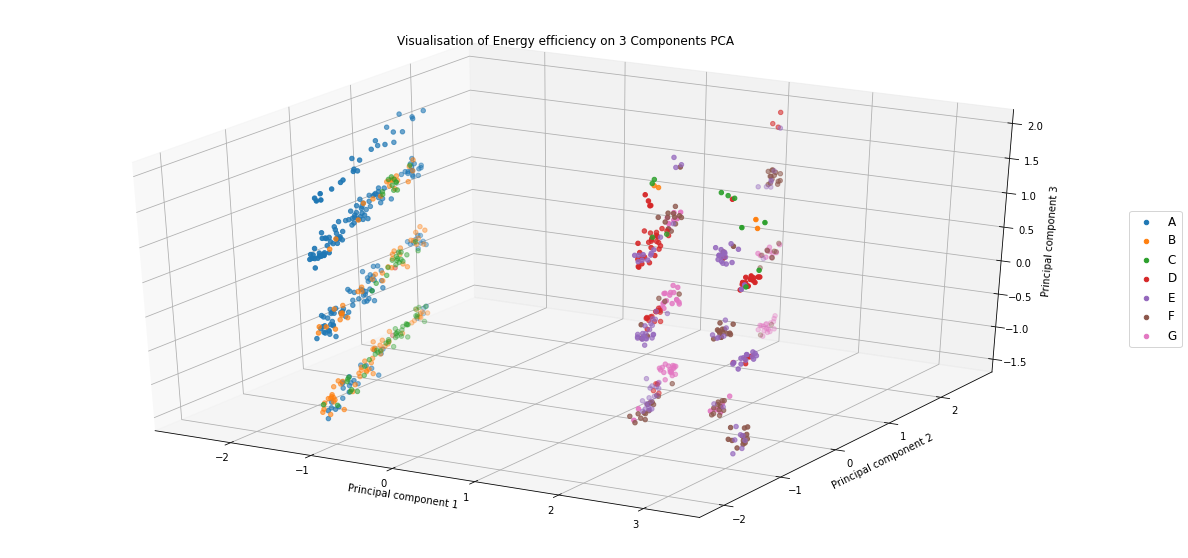

In [75]:
pca3 = PCA(n_components=3)
X3D = pd.DataFrame(pca3.fit_transform(std_data))
plot_3DPCA(X3D, target, Y2)

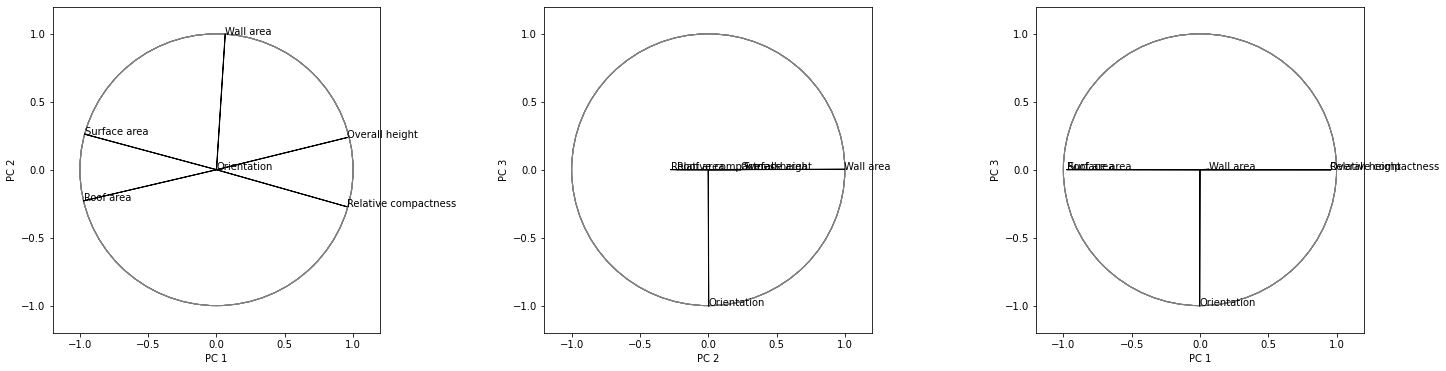

In [79]:
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
coord3=pca.components_[2]*np.sqrt(pca.explained_variance_[2])

c=plt.Circle((0,0), radius=1, color='gray', fill=False)
fig, axs = plt.subplots(1, 3, figsize=(23.5, 6))

for i, j, nom in zip(coord1,coord2, df.columns.values):
    axs[0].text(i, j, nom)
    axs[0].arrow(0,0,i,j,color='black')
    axs[0].add_patch(plt.Circle((0,0), radius=1, color='gray', fill=False))

for i, j, nom in zip(coord2,coord3, df.columns.values):
    axs[1].text(i, j, nom)
    axs[1].arrow(0,0,i,j,color='black')
    axs[1].add_patch(plt.Circle((0,0), radius=1, color='gray', fill=False))


for i, j, nom in zip(coord1,coord3, df.columns.values):
    axs[2].text(i, j, nom)
    axs[2].arrow(0,0,i,j,color='black')
    axs[2].add_patch(plt.Circle((0,0), radius=1, color='gray', fill=False))


for ax in axs:
    ax.axis((-1.2,1.2,-1.2,1.2))

axs[0].set(xlabel='PC 1', ylabel='PC 2')
axs[1].set(xlabel='PC 2', ylabel='PC 3')
axs[2].set(xlabel='PC 1', ylabel='PC 3')

plt.subplots_adjust(wspace=0.5)

#### Visualisation des outliers

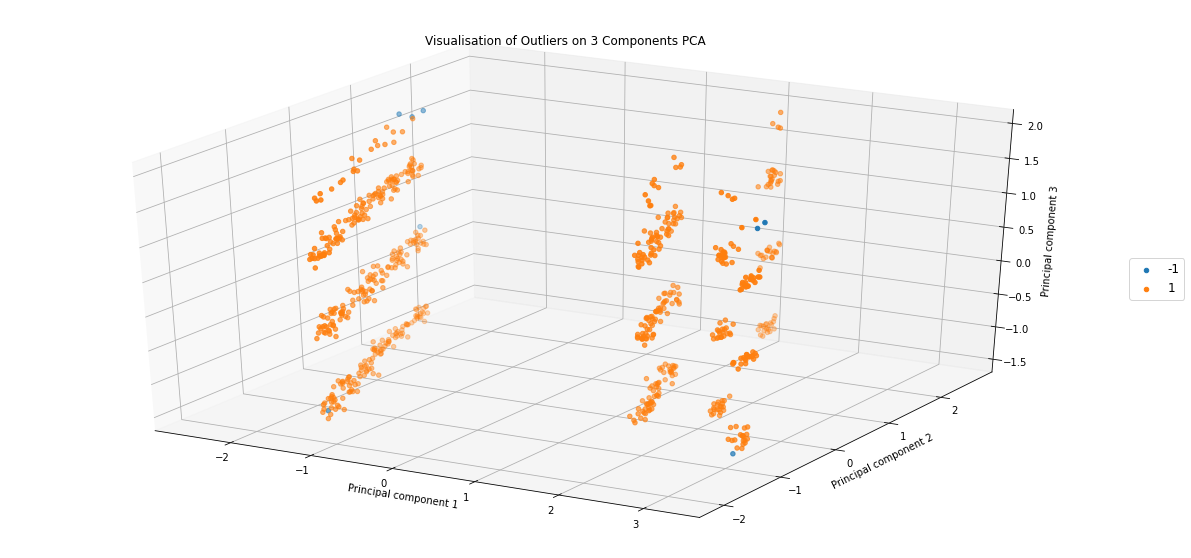

In [80]:
plot_3DPCA(X3D, pd.Series(isolF.predict(df[NUMERICAL])), "Outliers")

#### Pour réduction de dimensions

<BarContainer object of 6 artists>

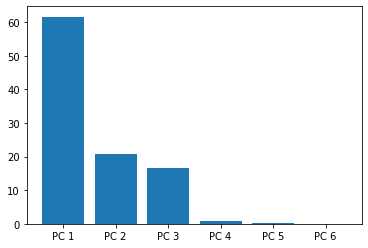

In [54]:
#model = PCA(n_components=6)
#X_reduced = model.fit_transform(df[NUMERICAL])

model = PCA()
X6D = model.fit_transform(std_data)

plt.bar(x = ['PC {}'.format(x) for x in range(1,len(model.explained_variance_ratio_)+1)], 
        height = model.explained_variance_ratio_*100)

In [55]:
#Nombre de composants minimal pour garder une variance > 99%
nb_comp_min = np.argmax(np.cumsum(model.explained_variance_ratio_) > 0.99)
print(nb_comp_min)

3


<BarContainer object of 3 artists>

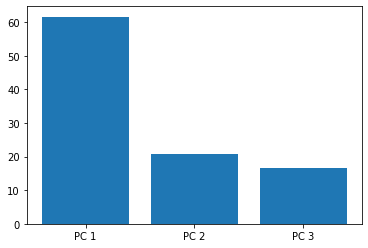

In [56]:
pca = PCA(n_components=0.95, svd_solver="full")
X3D = pca.fit_transform(std_data)

plt.bar(x = ['PC {}'.format(x) for x in range(1,len(pca.explained_variance_ratio_)+1)], 
        height = pca.explained_variance_ratio_*100)

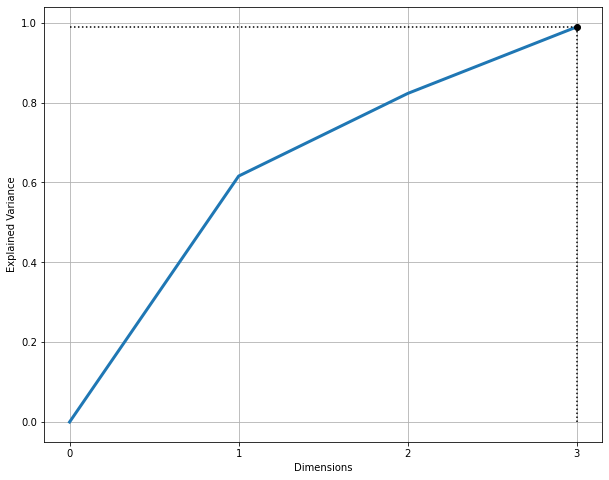

In [57]:
# create an array with sum of all explained_variance_ratio_
cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum = np.insert(cumsum, 0, 0., axis=0)

plt.figure(figsize=(10,8))
plt.plot(range(4), cumsum, linewidth=3)
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.xticks(range(4))
plt.plot([nb_comp_min, nb_comp_min], [0, 0.99], "k:")
plt.plot([0, nb_comp_min], [0.99, 0.99], "k:")
plt.plot(nb_comp_min, 0.99, "ko")
plt.grid(True)
#save_fig("explained_variance_plot")
plt.show()

## Clustering

In [58]:
from sklearn.cluster import KMeans

In [59]:
km = KMeans(n_clusters=7)
km.fit(df[NUMERICAL])

KMeans(n_clusters=7)

In [60]:
km.predict(df[NUMERICAL])

array([6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5,
       5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4,
       4, 4, 4, 4, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1,
       4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1,
       1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 3, 3, 3, 3,
       3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6,
       6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5,
       3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4,
       4, 4, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### Comparaison classes & clusters (visualisation sur 2 composantes principales)

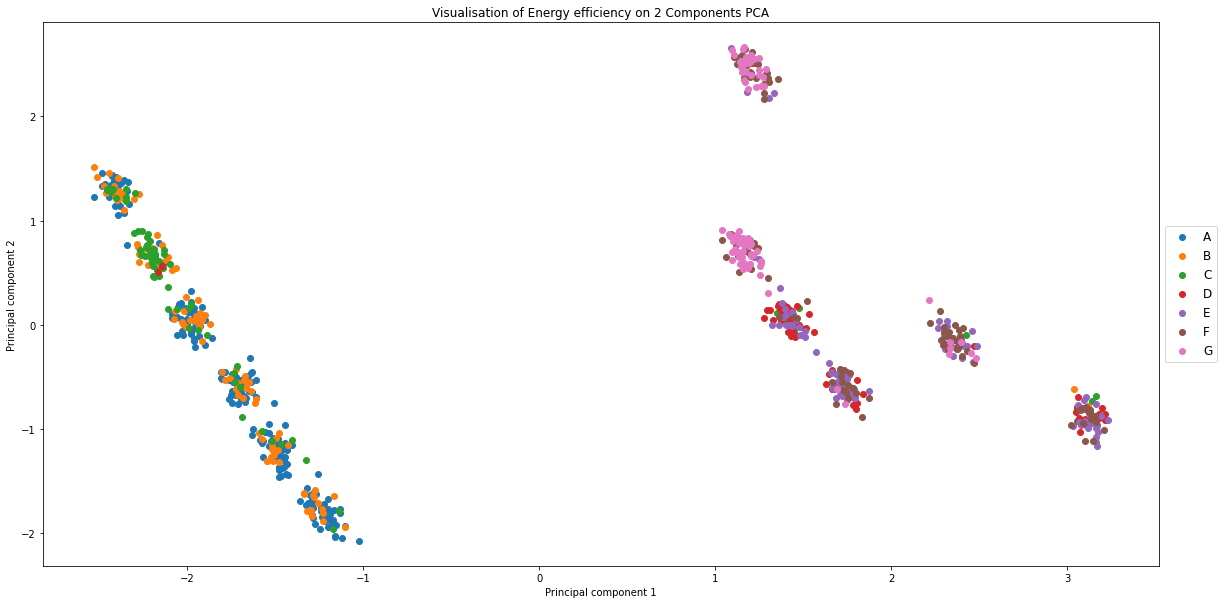

In [61]:
plot_2DPCA(X2D, target, Y2)

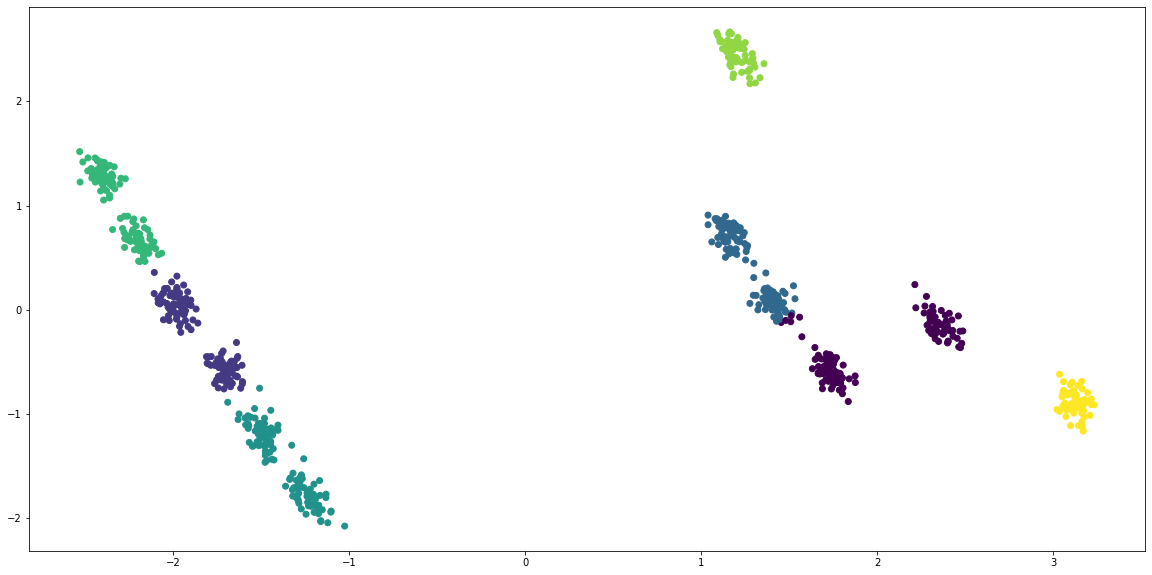

In [64]:
plt.figure(figsize=(20,10))
plt.scatter(X2D[0], X2D[1], c=km.predict(df[NUMERICAL]))

Approche K-Means pas pertinente.

## Prémices à l'encodage des données catégoriques

Feature "Orientation"

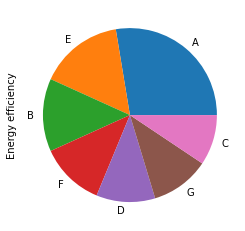

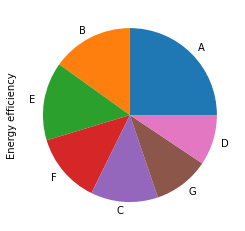

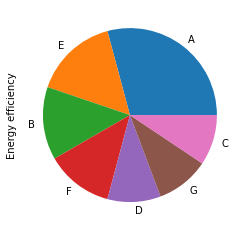

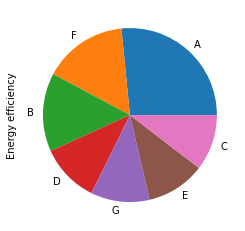

In [46]:
#Observation de la répartition des classes selon les différentes orientations.

df_nord = df[df['Orientation'] == 'North']
df_sud = df[df['Orientation'] == 'South']
df_est = df[df['Orientation'] == 'East']
df_ouest = df[df['Orientation'] == 'West']

for sub_df in (df_nord, df_sud, df_est, df_ouest):
    plt.figure()
    sub_df[Y2].value_counts().plot.pie()

Supposition : Est < Nord < Ouest < Sud
Vérification

1) tests d'hypothèses

In [56]:
from scipy.stats import ttest_ind #test d'indépendance

In [79]:
subdfs = [df_nord, df_sud, df_est, df_ouest]
names = ["nord", "sud", "est", "ouest"]
alpha=0.2

for i in range(len(subdfs)):
    for j in range(len(subdfs)):
        stat, p = ttest_ind(subdfs[i][Y1], subdfs[j][Y1])
        if p < alpha:
            print("Y1 présente un comportement significativement différent quand Orientation = "
                  + names[i]
                  + " et quand Orientation = "
                  + names[j]
                  + "(p = " + str(p) + ")")
        else:
            print("RAS pour la comparaison entre "
                  + names[i]
                  + " et "
                  + names[j]
                  + "(p = " + str(p) + ")")

RAS pour la comparaison entre nord et nord(p = 1.0)
RAS pour la comparaison entre nord et sud(p = 0.9032424207637202)
RAS pour la comparaison entre nord et est(p = 0.756478131195349)
RAS pour la comparaison entre nord et ouest(p = 0.8831050179936493)
RAS pour la comparaison entre sud et nord(p = 0.9032424207637202)
RAS pour la comparaison entre sud et sud(p = 1.0)
RAS pour la comparaison entre sud et est(p = 0.6604971274825793)
RAS pour la comparaison entre sud et ouest(p = 0.9779915197187365)
RAS pour la comparaison entre est et nord(p = 0.756478131195349)
RAS pour la comparaison entre est et sud(p = 0.6604971274825793)
RAS pour la comparaison entre est et est(p = 1.0)
RAS pour la comparaison entre est et ouest(p = 0.6450104182394298)
RAS pour la comparaison entre ouest et nord(p = 0.8831050179936493)
RAS pour la comparaison entre ouest et sud(p = 0.9779915197187365)
RAS pour la comparaison entre ouest et est(p = 0.6450104182394298)
RAS pour la comparaison entre ouest et ouest(p = 1.0

In [40]:
#On réentraine le modèle avec le nombre de composants trouvé
model = PCA(n_components=3)
X_reduced = model.fit_transform(df[NUMERICAL])

In [39]:
np.argmax(np.cumsum(model.explained_variance_ratio_) > 0.99)
#Nombre de composants minimal pour garder une variance > 99%

1

Text(0, 0.5, 'Variance')

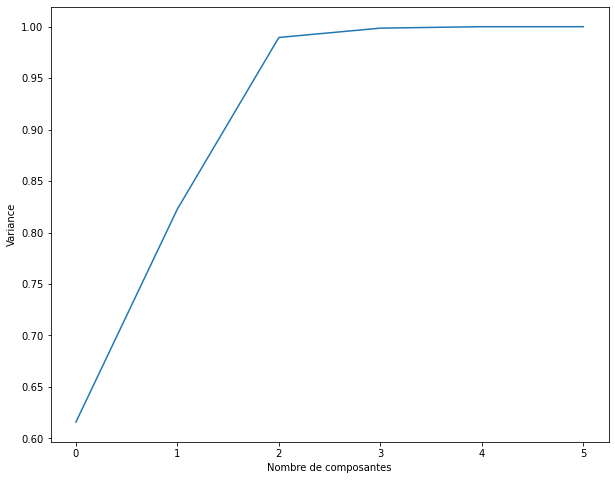

In [47]:
plt.figure(figsize=(10,8))
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance")